# Deep Q-Learning - Lunar Lander


## Import Packages


In [1]:
import time
from collections import OrderedDict, deque, namedtuple

import gymnasium as gym
import numpy as np
import PIL.Image
import torch
import utils
from torch import nn

torch.set_default_dtype(torch.float64)

## Hyperparameters


In [2]:
MEMORY_SIZE = 100_000  # size of memory buffer
GAMMA = 0.995  # discount factor
ALPHA = 1e-3  # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## Load environment


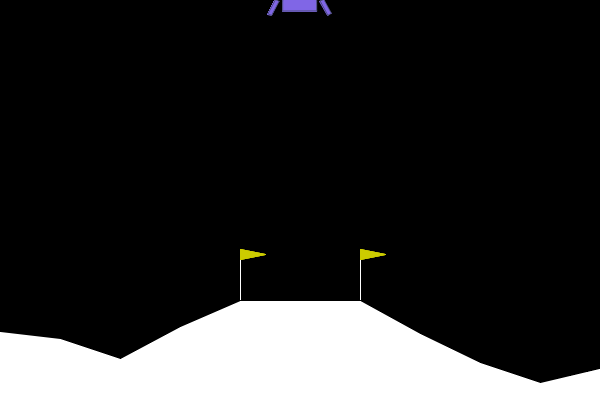

In [3]:
environment = gym.make("LunarLander-v2", render_mode="rgb_array")
environment.reset()
PIL.Image.fromarray(environment.render())

In [4]:
state_size = environment.observation_space.shape
num_actions = environment.action_space.n

print("State Shape:", state_size)
print("Number of actions:", num_actions)

State Shape: (8,)
Number of actions: 4


In [5]:
# Reset the environment and get the initial state.
current_state, _ = environment.reset()

In [6]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, *_ = environment.step(action)

# Display table with values.
utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

/home/al/projects/coursera/ml_spec_torch/c_3_unsupervised_learning_recommenders_reinforcement_learning/week3/utils.py:365: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .style.applymap(lambda x: "background-color : grey" if x == "" else "")


## Deep Q-Learning


In [7]:
# torch.manual_seed(123)

q_network = nn.Sequential(
    nn.Linear(state_size[0], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions),
)

target_q_network = nn.Sequential(
    nn.Linear(state_size[0], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions),
)

optimizer = torch.optim.Adam(params=q_network.parameters(), lr=ALPHA)

In [8]:
# Store experiences as named tuples
experience = namedtuple(
    "Experience", field_names=["state", "action", "reward", "next_state", "done"]
)

### Loss


In [9]:
mse_loss = nn.MSELoss()


def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences

    with torch.no_grad():
        max_qsa = torch.max(target_q_network(next_states), dim=1).values
        y = (rewards + gamma * (1 - done_vals) * max_qsa).unsqueeze(1)

    q_values = torch.take_along_dim(q_network(states), actions.unsqueeze(1), dim=1)

    loss = mse_loss(q_values, y)

    return loss

### Soft Update


In [10]:
def soft_update(q_network, target_q_network):
    TAU = 1e-3  # Soft update parameter.

    new_params = OrderedDict()
    current_params = target_q_network.state_dict()

    for name, param in q_network.state_dict().items():
        new_params[name] = TAU * param + (1.0 - TAU) * current_params[name]

    target_q_network.load_state_dict(new_params)

### Training


In [11]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100  # number of total points to use for averaging
epsilon = 1.0  # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N

memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.load_state_dict(q_network.state_dict())

for i in range(num_episodes):
    # Reset the environment to the initial state and get the initial state
    state, _ = environment.reset()
    total_points = 0

    for t in range(max_num_timesteps):
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = (
            torch.from_numpy(state).unsqueeze(0).type(torch.float64)
        )  # state needs to be the right shape for the q_network

        with torch.no_grad():
            q_values = q_network(state_qn)

        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, *_ = environment.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(
            experience(
                state,
                action,
                reward,
                next_state,
                done,
            )
        )

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            optimizer.zero_grad()

            loss = compute_loss(experiences, GAMMA, q_network, target_q_network)

            loss.backward()

            optimizer.step()

            soft_update(q_network, target_q_network)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(
        f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}",
        end="",
    )

    if (i + 1) % num_p_av == 0:
        print(
            f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}"
        )

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        torch.save(q_network.state_dict(), "./lunar_lander_model.pt")
        break


tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -167.70
Episode 200 | Total point average of the last 100 episodes: -109.89
Episode 300 | Total point average of the last 100 episodes: -46.555
Episode 400 | Total point average of the last 100 episodes: 47.529
Episode 500 | Total point average of the last 100 episodes: 189.10
Episode 526 | Total point average of the last 100 episodes: 200.78

Environment solved in 526 episodes!

Total Runtime: 497.65 s (8.29 min)


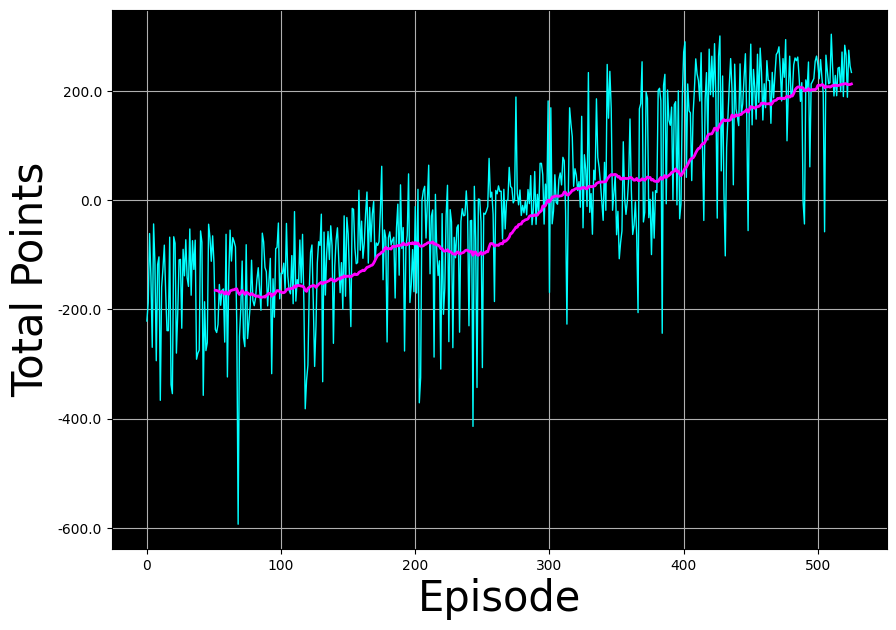

In [12]:
# Plot the total point history along with the moving average
utils.plot_history(total_point_history)

In [13]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, environment, q_network)
utils.embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x608e480] Warning: data is not aligned! This can lead to a speed loss


[ 0.00329161  1.4169114   0.33338794  0.26627648 -0.00380734 -0.07551728
  0.          0.        ]
[ 0.00649071  1.422322    0.3213404   0.24047527 -0.00521329 -0.0281207
  0.          0.        ]
[ 0.00959358  1.42713     0.3092571   0.21368901 -0.00419471  0.02037366
  0.          0.        ]
[ 0.01269655  1.4313377   0.3092534   0.18701784 -0.00317694  0.02035718
  0.          0.        ]
[ 0.01579933  1.4349456   0.30925065  0.16034909 -0.00215879  0.02036468
  0.          0.        ]
[ 1.8902112e-02  1.4379535e+00  3.0924779e-01  1.3368082e-01
 -1.1408144e-03  2.0361526e-02  0.0000000e+00  0.0000000e+00]
[ 2.2004891e-02  1.4403613e+00  3.0924475e-01  1.0701251e-01
 -1.2300728e-04  2.0358177e-02  0.0000000e+00  0.0000000e+00]
[2.5107574e-02 1.4421690e+00 3.0924171e-01 8.0344148e-02 8.9464703e-04
 2.0355035e-02 0.0000000e+00 0.0000000e+00]
[0.02821026 1.4433767  0.3092387  0.05367573 0.00191214 0.02035188
 0.         0.        ]
[0.0312232  1.4439912  0.2979975  0.02730566 0.0051821

In [1]:
import numpy as np

A2 = np.array([[0.21292656, 0.21274673, 0.21295976]])

Y = np.array([[1, 0, 1]])

float(np.squeeze(np.sum(np.dot(Y, A2.T))))

0.42588632

In [5]:
A2 = np.array([[1, 1, 1], [2, 2, 2]])
np.dot(A2, A2.T)

array([[ 3,  6],
       [ 6, 12]])

In [2]:
import torch
from torch.nn import CrossEntropyLoss

loss = CrossEntropyLoss()

In [32]:
loss(torch.tensor([[0.0, 0.0, 5]]), torch.tensor([[0.0, 0.0, 1.0]]))

tensor(0.0134)

In [22]:
import numpy as np

np.log(0)

/tmp/ipykernel_21323/2049926572.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [34]:
p = np.array([0.0, 0.0, 5])

-np.array([0.0, 0.0, 1.0]) * np.log((np.exp(p) / np.exp(p).sum())).sum()

array([ 0.        ,  0.        , 10.04015771])

In [20]:
import numpy as np
from PIL import Image

lena = Image.open("../../lena.png")

lena = np.asarray(lena)

lena.shape

(512, 512, 3)

In [25]:
np.pad(lena, ((1, 1), (1, 1), (0, 0))).shape

(514, 514, 3)

In [1]:
import numpy as np
from PIL import Image

lena = Image.open("../../lena.png").convert("L")

lena = np.asarray(lena)

lena.shape

(512, 512)

In [40]:
a = np.zeros((2, 2, 2))
a

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [43]:
a[0, :, 1]

array([2., 3.])

In [41]:
a[0, :, 1] = [2, 3]

In [50]:
kernel = np.array([[0, 1, -1, 0], [1, 3, -3, -1], [1, 3, -3, -1], [0, 1, -1, 0]])
kernel.shape

(4, 4)

In [59]:
kernel[0:2, 1:3]

array([[ 1, -1],
       [ 3, -3]])

In [63]:
list(range(0, 10, 4))

[0, 4, 8]

In [3]:
from scipy.ndimage import convolve

c = convolve(lena, kernel)

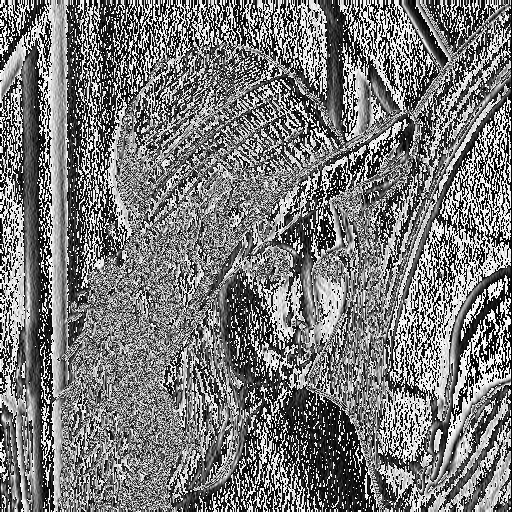

In [4]:
img = Image.fromarray(c, "L")
img

In [19]:
lena

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

In [9]:
5 * 5 * 100 * 3 + 100

7600

In [ ]:
127 * 127 * 16 x 5*5*32

In [11]:
(127 - 5) / 2 + 1

62.0